<a href="https://colab.research.google.com/github/Shreya-singh01/Anti-Spoofing-Detector/blob/main/Anti_Spoofing_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install ultralytics
!pip install cvzone
!pip install opencv-python-headless
!pip install mediapipe

In [43]:
!git clone --depth 1 --filter=blob:none --sparse https://github.com/Shreya-singh01/Anti-Spoofing-Detector.git
%cd Anti-Spoofing-Detector
!git sparse-checkout set collected_images

Cloning into 'Anti-Spoofing-Detector'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 0), reused 23 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 213.99 KiB | 4.04 MiB/s, done.
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 2 (delta 0), reused 1 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (2/2), 313.65 KiB | 5.32 MiB/s, done.
/content/Anti-Spoofing-Detector/Anti-Spoofing-Detector
remote: Enumerating objects: 8536, done.
remote: Counting objects: 100% (8536/8536), done.
remote: Compressing objects: 100% (8536/8536), done.
remote: Total 8536 (delta 0), reused 8536 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8536/8536), 46.76 MiB | 23.41 MiB/s, done.
Updating files: 100% (8743/8743), done.


In [44]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Directories for labeled data
real_dir = os.path.join('collected_images', 'real')
fake_dir = os.path.join('collected_images', 'fake')

# Output directories for train, validation, and test sets
split_data_dir = 'SplitData'
train_dir = os.path.join(split_data_dir, 'train')
val_dir = os.path.join(split_data_dir, 'val')
test_dir = os.path.join(split_data_dir, 'test')

# Create directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

def get_all_images_from_subdirs(main_dir):
    images = []
    for subdir in sorted(os.listdir(main_dir)):
        subdir_path = os.path.join(main_dir, subdir)
        if os.path.isdir(subdir_path):
            images.extend([os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if f.endswith('.jpg')])
    return images

# Get the list of image files for each label from subdirectories 0001 to 0010
real_images = get_all_images_from_subdirs(real_dir)
fake_images = get_all_images_from_subdirs(fake_dir)

# Split real images into train, validation, and test sets
real_train, real_val_test = train_test_split(real_images, test_size=0.3, random_state=42)
real_val, real_test = train_test_split(real_val_test, test_size=0.5, random_state=42)

# Split fake images into train, validation, and test sets
fake_train, fake_val_test = train_test_split(fake_images, test_size=0.3, random_state=42)
fake_val, fake_test = train_test_split(fake_val_test, test_size=0.5, random_state=42)

# Helper function to save split data into respective directories
def save_split(images, directory, label):
    label_dir = os.path.join(directory, label)
    os.makedirs(label_dir, exist_ok=True)
    for img_path in images:
        shutil.copy(img_path, label_dir)

# Save the splits into train, validation, and test directories under SplitData
save_split(real_train, train_dir, 'real')
save_split(fake_train, train_dir, 'fake')

save_split(real_val, val_dir, 'real')
save_split(fake_val, val_dir, 'fake')

save_split(real_test, test_dir, 'real')
save_split(fake_test, test_dir, 'fake')

print("Data has been successfully split and saved into the SplitData directory.")


Data has been successfully split and saved into the SplitData directory.


In [45]:
#TRAINING THE MODEL
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/train',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/val',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary output for real/fake
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=370,
    epochs=20,
    validation_data=val_generator,
    validation_steps=79
)


Found 6109 images belonging to 2 classes.
Found 1309 images belonging to 2 classes.
Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 79s 199ms/step - accuracy: 0.8819 - loss: 0.2732 - val_accuracy: 0.9945 - val_loss: 0.0174
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 61s 165ms/step - accuracy: 0.9952 - loss: 0.0200 - val_accuracy: 0.9984 - val_loss: 0.0052
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 59s 160ms/step - accuracy: 0.9981 - loss: 0.0084 - val_accuracy: 0.9960 - val_loss: 0.0229
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9949 - loss: 0.0037 - val_accuracy: 1.0000 - val_loss: 7.1640e-04
Epoch 7/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 59s 160ms/step - accuracy: 0.9915 - loss: 0.0298 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoc

In [ ]:
import matplotlib.pyplot as plt

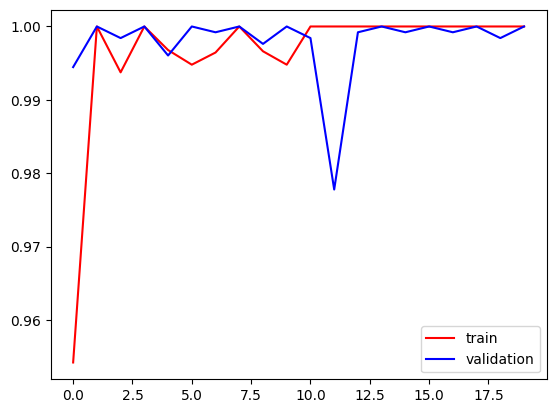

In [47]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

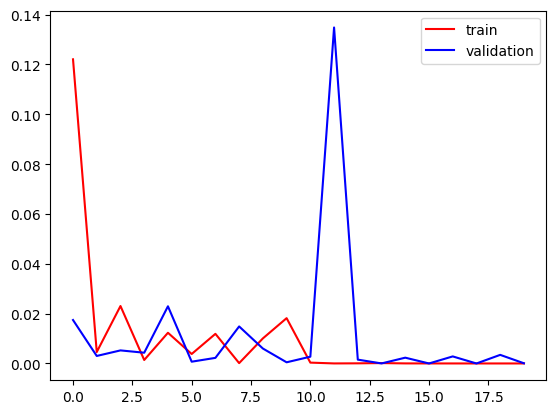

In [48]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

##Regularized model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/train',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/val',
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

# Build the model with various regularizations
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Use early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=370,
    epochs=20,
    validation_data=val_generator,
    validation_steps=79,
    callbacks=[early_stopping]
)


Found 6109 images belonging to 2 classes.
Found 1309 images belonging to 2 classes.
Epoch 1/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 86s 222ms/step - accuracy: 0.8089 - loss: 0.7101 - val_accuracy: 0.6329 - val_loss: 5.7586
Epoch 2/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9531 - loss: 0.3025 - val_accuracy: 0.6667 - val_loss: 5.2418
Epoch 3/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 140s 222ms/step - accuracy: 0.9474 - loss: 0.3302 - val_accuracy: 0.8758 - val_loss: 0.6486
Epoch 4/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9427 - loss: 0.3138 - val_accuracy: 0.8889 - val_loss: 0.5125
Epoch 5/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 92s 249ms/step - accuracy: 0.9669 - loss: 0.2781 - val_accuracy: 0.9280 - val_loss: 0.3678
Epoch 6/20
370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9639 - loss: 0.2603 - val_accuracy: 0.9556 - val_loss: 0.3698
Epoch 7/20
 13/370 ━━━━━━━━━━━━━━━━━━━━ 1:08 191ms/step - accuracy: 0.9804 - loss: 0.2243

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

## Testing

In [ ]:
# Evaluate the model on the test set
test_generator = test_datagen.flow_from_directory(
    '/content/Anti-Spoofing-Detector/SplitData/test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc}")

# Save the model for future use
model.save('anti_spoofing_model.h5')


In [ ]:
# Testing the model on a sample image
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    return img_array

def predict_image(img_path):
    img_array = preprocess_image(img_path)
    prediction = model.predict(img_array)
    if prediction[0][0] > 0.5:
        print(f"{img_path} is predicted as Real (1)")
    else:
        print(f"{img_path} is predicted as Fake (0)")


# Replace 'path_to_image' with the path to an image you want to test
predict_image('/content/Anti-Spoofing-Detector/collected_images/fake/0004/0004_01_00_01_125.jpg')

In [ ]:
# Replace 'path_to_image' with the path to an image you want to test
predict_image('/content/Anti-Spoofing-Detector/collected_images/real/0007/0007_00_00_01_101.jpg')

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
from PIL import Image
from io import BytesIO

def capture_image():
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);
            document.body.appendChild(div);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = () => resolve());
            video.play();

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            video.remove();
            div.remove();
            return canvas.toDataURL('image/jpeg').replace(/^data:image\\/jpeg;base64,/, '');
        }
        ''')
    display(js)
    data = eval_js('takePhoto()')
    img = Image.open(BytesIO(b64decode(data)))
    return img

# Capture the image
img = capture_image()

# Convert the image to an OpenCV format
img = np.array(img)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Save the captured image
cv2.imwrite('captured_image.jpg', img)

# Display the image
from google.colab.patches import cv2_imshow
cv2_imshow(img)


In [ ]:
import cv2

def detect_faces(image_path):
    # Load the pre-trained Haar Cascade face detector from OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Read the image
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) > 0:
        # Get the first detected face
        x, y, w, h = faces[0]
        bounding_box = {"x": x, "y": y, "w": w, "h": h}
    else:
        bounding_box = None  # No faces detected

    return bounding_box

def crop_face(image_path, bounding_box):
    img = cv2.imread(image_path)
    if bounding_box:
        x, y, w, h = bounding_box["x"], bounding_box["y"], bounding_box["w"], bounding_box["h"]
        # Calculate the coordinates of the cropping box
        x1, y1 = x, y
        x2, y2 = x + w, y + h

        # Crop the face part
        cropped_face = img[y1:y2, x1:x2]

        return cropped_face
    else:
        return None  # No face to crop

# Example usage
image_path = '/content/Anti-Spoofing-Detector/captured_image.jpg'
bounding_box = detect_faces(image_path)
cropped_face = crop_face(image_path, bounding_box)

if cropped_face is not None:
    # Save the cropped face image
    output_path = '/content/cropped_face.jpeg'
    cv2.imwrite(output_path, cropped_face)
    print(f"Cropped face saved at {output_path}")
else:
    print("No face detected or unable to crop.")



In [ ]:
predict_image('/content/cropped_face.jpeg')